In [1]:
import sys
sys.path.append('F:\project\python_project\dswork')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split,cross_val_score
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve
from sklearn.model_selection import StratifiedKFold
from bayes_opt import BayesianOptimization
import scorecardpy as sc
from unity.fea_eda_func import FeaEdaFunc
from unity.perf_func import PertFunc
import warnings
plt.style.use('ggplot')

In [2]:
warnings.filterwarnings('ignore')

In [3]:
bhv = pd.read_csv('data\附件1 CustBehavior.csv')
tag = pd.read_csv('data\附件2 TrainFlag.csv')
out = pd.read_csv('data\附件3 TestPRED.csv')

In [4]:
bhv = bhv.rename({'HIS_DW_DATE':'date','ACCOUNT':'uid'},axis=1)
tag = tag.rename({'BAD_FLAG':'tag','ACCOUNT':'uid'},axis=1)
out = out.rename({'ACCOUNT':'uid'},axis=1)

解读说明：以2020年3月1日为观察点，构建行为特征与基本信息特征

In [5]:
bhv.shape

(188061, 37)

In [6]:
bhv.head()

,uid,FEE1,FEE2,FEE3,FEE4,FEE5,FEE6,TOTAL_FEE,SONG_LIS_NUM,SONG_DOW_NUM,SONG_TOTAL_FEE,COS_TOTAL_FEE,LIM_DOW_NUM,INV_TOTAL_FEE,ACU_TOTAL_FEE,CLOSE_BAL,CLSBAL_FLAG,PRE_LIMIT_FEE,INSTL_AMT,INT_CHDCMP,INT_CHGD,INT_CMPOND,INT_CUNOT,MIN_DUE,OPEN_BAL,OPBAL_FLAG,OTHER_FEES,PAYMENT,PURCHASES,BAL_MP,NBR_CASHAD_NEW,NBR_FEEDTY_NEW,NBR_OTHERS_NEW,NBR_PAYMNT_NEW,NBR_PURCH_NEW,MTHS_ODUE,date
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.330408,0.678034,0.0,0.0,0.551596,0.0,0.0,0.0,0.678489,+,0.716874,0.594090,0.558967,0.552494,0.0,0.0,0.594090,0.649947,+,0.0,0.649937,0.678345,0.0,0,0,0,1,4,0,2020/3/1
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.339423,0.648463,0.0,0.0,0.570442,0.0,0.0,0.0,0.649947,+,0.716874,0.570037,0.574217,0.571536,0.0,0.0,0.570037,0.682880,+,0.0,0.682870,0.648760,0.0,0,0,0,1,1,0,2020/2/1
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.321717,0.682126,0.0,0.0,0.579808,0.0,0.0,0.0,0.682880,+,0.716874,0.601645,0.544263,0.580209,0.0,0.0,0.601645,0.639227,+,0.0,0.639217,0.682439,0.0,0,0,0,1,1,0,2020/1/1
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.638989,0.0,0.0,0.477584,0.0,0.0,0.0,0.639227,+,0.716874,0.547541,0.000000,0.477584,0.0,0.0,0.547541,0.669317,+,0.0,0.669307,0.639282,0.0,0,0,0,1,1,0,2019/12/1
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.308998,0.669116,0.0,0.0,0.516747,0.0,0.0,0.0,0.669317,+,0.716874,0.581409,0.522745,0.516776,0.0,0.0,0.581409,0.625942,+,0.0,0.625933,0.669423,0.0,0,0,0,1,2,0,2019/11/1


In [7]:
tag.head()

,uid,DAY_OPENED,tag
0,0,20190430,0
1,1,20170512,0
2,2,20190129,0
3,3,20161026,0
4,4,20180910,0


### 1.特征衍生与合并

In [8]:
# 观察点
obj_date = datetime.date(2020,3,1)

In [9]:
bhv['date'] = pd.to_datetime(bhv['date']).dt.date
bhv.loc[:,['CLSBAL_FLAG','OPBAL_FLAG']] = bhv.loc[:,['CLSBAL_FLAG','OPBAL_FLAG']].replace({'+':0,'-':1})

In [10]:
exp_feas = set(['uid','CLSBAL_FLAG','OPBAL_FLAG','date','NBR_PURCH_NEW','MTHS_ODUE'])
num_feas = list(set(bhv.columns)-exp_feas)
spc_feas = ['CLSBAL_FLAG','OPBAL_FLAG','CLOSE_BAL']

In [11]:
camp= lambda x:0 if x[x==1].count() == 0 else x[x==0].count()/x[x==1].count() 
pct = lambda x:np.nan if x.values[0] == 0 else x.values[-1]/x.values[0]-1 

#### 1.1 滑动窗口行为特征衍生

In [12]:
# 近N月消费、推荐、下载行为特征 N=1，3，6，9，12
# 近N月累计会员次数、累计正向消费次数、负正向消费比，账户余额变化
bhvn_lis = []
for n in [1,3,6,9,12]:
    ddate = obj_date - relativedelta(months=n)
    bhvsele = bhv[bhv['date'].between(ddate,obj_date)]
    bhvn = bhvsele.groupby(['uid'])[num_feas].agg(['sum','max','min','mean'])
    bhvn.columns = [f'_{n}_'.join(col).upper() for col in bhvn.columns.values]
    bhvs = bhvsele.groupby(['uid'])[spc_feas].agg({'OPBAL_FLAG':'sum','CLSBAL_FLAG':['sum',camp],'CLOSE_BAL':pct})
    bhvs = bhvs.rename({'<lambda_0>':'camp','<lambda>':'pct'},axis=1)
    bhvs.columns = [f'_{n}_'.join(col).upper() for col in bhvs.columns.values]
    bhvn = pd.concat([bhvn,bhvs],axis=1)
    bhvn_lis.append(bhvn)

In [13]:
bhvnall = pd.concat(bhvn_lis,axis=1).reset_index()

In [14]:
dataset = bhv[bhv['date'] == obj_date].merge(bhvnall,on=['uid'])

In [15]:
train_set = dataset.merge(tag,on=['uid'])
out_set = dataset.merge(out,on=['uid'])

#### 1.2 注册时间距离观察点时间特征衍生

In [16]:
train_set['DAY_OPENED'] = pd.to_datetime(train_set['DAY_OPENED'],format='%Y%m%d').dt.date
out_set['DAY_OPENED'] = pd.to_datetime(out_set['DAY_OPENED'],format='%Y%m%d').dt.date

In [17]:
train_set['until_days'] = (obj_date-train_set['DAY_OPENED']).dt.days
train_set['until_months'] = (obj_date-train_set['DAY_OPENED']).dt.days/30
train_set['until_weeks'] = (obj_date-train_set['DAY_OPENED']).dt.days/7

out_set['until_days'] = (obj_date-out_set['DAY_OPENED']).dt.days
out_set['until_months'] = (obj_date-out_set['DAY_OPENED']).dt.days/30
out_set['until_weeks'] = (obj_date-out_set['DAY_OPENED']).dt.days/7

### 2.特征筛选

#### 2.1 剔除缺失率大于0.7的特征

In [18]:
explore_drop_feas = []

In [19]:
null_cnt = 1-train_set.count()/15000
explore_drop_feas.extend(list(null_cnt[null_cnt > 0.7].index))

#### 2.2 剔除单一特征

In [20]:
unique_cnt = train_set.apply(lambda x:len(x.unique()))
explore_drop_feas.extend(list(unique_cnt[unique_cnt == 1].index))

In [21]:
train_set = train_set.drop(explore_drop_feas,axis=1)
out_set = out_set.drop(explore_drop_feas,axis=1)

#### 2.3 划分数据集

* 因为聚合样本总共20000条，样本较少，为简化模型，所以不进行采用分注册月度分层采样操作

In [22]:
train_x = train_set.drop(['DAY_OPENED','uid','tag'],axis=1)
train_y = train_set['tag']
out_x = out_set.drop(['DAY_OPENED','uid'],axis=1)

In [23]:
tra_x,tst_x,tra_y,tst_y = train_test_split(train_x,train_y,test_size=0.3,random_state=0,shuffle=True)

In [24]:
tra_x = tra_x.reset_index(drop=True)
tra_y = tra_y.reset_index(drop=True)
tst_x = tst_x.reset_index(drop=True)
tst_y = tst_y.reset_index(drop=True)

In [25]:
tra_y.value_counts()

0    9773
1     727
Name: tag, dtype: int64

In [26]:
tst_y.value_counts()

0    4181
1     319
Name: tag, dtype: int64

#### 2.4 K折交叉验证筛选特征

In [27]:
# skf = StratifiedKFold(10,shuffle=True,random_state=0)
# sele = set()
# n = 1
# for tra_index,tst_index in skf.split(tra_x,tra_y):
#     print(f'第{n}折')
#     ktrax = tra_x.iloc[tra_index,:]
#     ktray = tra_y.iloc[tra_index]
#     ktstx = tra_x.iloc[tst_index,:]
#     ktxty = tra_y.iloc[tst_index]
#     clf = LGBMClassifier(random_state=0)
#     clf.fit(ktrax,ktray)
#     imp = pd.DataFrame(clf.feature_importances_,index=tra_x.columns,columns=['importance']).sort_values('importance',ascending=False)
#     sele = sele | set(imp['importance'].head(50).index)
#     n+=1

In [28]:
clf = LGBMClassifier(random_state=0)
clf.fit(tra_x,tra_y)
tra_pred_y = clf.predict_proba(tra_x)[:,1]
imp = pd.DataFrame(clf.feature_importances_,index=tra_x.columns,columns=['importance']).sort_values('importance',ascending=False)
sele = set(imp['importance'].head(200).index)

In [29]:
tra_x = tra_x[sele]
tst_x = tst_x[sele]
out_x = out_x[sele]

#### 2.5 决策树分箱

In [30]:
tra_x = pd.concat([tra_x,tra_y],axis=1)
tst_x = pd.concat([tst_x,tst_y],axis=1)

In [31]:
bins_dic = sc.woebin(tra_x,y='tag',var_skip=['CLSBAL_FLAG','OPBAL_FLAG'])

[INFO] creating woe binning ...
Binning on 10500 rows and 201 columns in 00:00:40


#### 2.6 IV值筛选

In [32]:
iv_df = FeaEdaFunc.filter_fea(bins_dic)
iv_drop = iv_df[iv_df['iv']<0.1].index.to_list()

In [33]:
tra_x = tra_x.drop(iv_drop,axis=1)
tst_x = tst_x.drop(iv_drop,axis=1)
out_x = out_x.drop(iv_drop,axis=1)

In [34]:
bins_drop_dic = [bins_dic.pop(k) for k in iv_drop]

#### 2.7 PSI筛选

In [35]:
psi_info = FeaEdaFunc.calc_psi(bins_dic,tra_x,tst_x)[0]

In [36]:
psi_df = pd.DataFrame(psi_info,index=['psi']).T.sort_values('psi',ascending=False)

In [37]:
psi_drop = set(psi_df[psi_df['psi']>0.05].index)

In [38]:
tra_x = tra_x.drop(psi_drop,axis=1)
tst_x = tst_x.drop(psi_drop,axis=1)
out_x = out_x.drop(psi_drop,axis=1)

#### 2.8 WOE转化

In [39]:
tra_x = tra_x.drop('tag',axis=1)
tst_x = tst_x.drop('tag',axis=1)

In [40]:
tra_x_woe = sc.woebin_ply(tra_x,bins_dic)
tst_x_woe = sc.woebin_ply(tst_x,bins_dic)
out_x_woe = sc.woebin_ply(out_x,bins_dic)

[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [41]:
xv = tra_x_woe.values
np.where(xv==np.nan)

(array([], dtype=int64), array([], dtype=int64))

In [42]:
x = (1-tra_x_woe.count()/10500)
x[x>0]

Series([], dtype: float64)

### 3 建立模型

#### 3.1 初步模型

In [43]:
clf = LGBMClassifier(num_leaves=10,reg_alpha=0.01,reg_lambda=0.01,max_depth=10,random_state=0)
clf.fit(tra_x_woe,tra_y)
tra_pred_y = clf.predict_proba(tra_x_woe)[:,1]
tra_pred_tag = clf.predict(tra_x_woe)
tst_pred_y = clf.predict_proba(tst_x_woe)[:,1]
tst_pred_tag = clf.predict(tst_x_woe)

In [44]:
roc_auc_score(tra_y,tra_pred_y)

0.9252843537292411

In [45]:
roc_auc_score(tst_y,tst_pred_y)

0.8021666907843289

In [46]:
mat = confusion_matrix(tst_y,tst_pred_tag)
recall = mat[0,0]/(mat[0,0]+mat[0,1])
print(f'recall:{recall:.6f}')

recall:0.994260


In [47]:
mat = confusion_matrix(tra_y,tra_pred_tag)
recall = mat[0,0]/(mat[0,0]+mat[0,1])
print(f'recall:{recall:.6f}')

recall:0.997647


#### 3.2 贝叶斯调参

In [83]:
def lgb_cv(n_estimators,num_leaves,reg_lambda,max_depth):
    params = {'n_estimators':int(n_estimators),'num_leaves':int(num_leaves),'reg_lambda':float(reg_lambda),'max_depth':int(max_depth)}
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    auc_lis = []
    for k,(tra_index,tst_index) in enumerate(skf.split(tra_x_woe,tra_y)):
        ktrax = tra_x_woe.values[tra_index]
        ktray = tra_y.values[tra_index]
        ktstx = tra_x_woe.values[tst_index,:]
        ktsty = tra_y.values[tst_index]
        clf = LGBMClassifier(**params,random_state=0)
        clf.fit(ktrax,ktray)
        ktst_pred = clf.predict_proba(ktstx)[:,1]
        auc = roc_auc_score(ktsty,ktst_pred)
        auc_lis.append(auc)
    mauc = np.mean(auc_lis)
    return mauc
                          
lgb_op = BayesianOptimization(lgb_cv,{'n_estimators': (80, 250),
                                      'num_leaves': (2, 30),
                                      'reg_lambda':(0.01,0.1),
                                      'max_depth': (5, 30)},
                             random_state=0)

lgb_op.maximize()

|   iter    |  target   | max_depth | n_esti... | num_le... | reg_la... |
-------------------------------------------------------------------------
|  1        |  0.8092   |  18.72    |  201.6    |  18.88    |  0.05904  |
|  2        |  0.811    |  15.59    |  189.8    |  14.25    |  0.09026  |
|  3        |  0.8109   |  29.09    |  145.2    |  24.17    |  0.0576   |
|  4        |  0.8278   |  19.2     |  237.4    |  3.989    |  0.01784  |
|  5        |  0.8027   |  5.505    |  221.5    |  23.79    |  0.0883   |
|  6        |  0.8275   |  27.66    |  238.4    |  2.0      |  0.01084  |
|  7        |  0.8091   |  25.82    |  250.0    |  15.29    |  0.01     |
|  8        |  0.8242   |  19.28    |  236.3    |  4.41     |  0.0593   |
|  9        |  0.8276   |  22.36    |  240.9    |  2.0      |  0.01     |
|  10       |  0.8276   |  13.61    |  241.2    |  3.552    |  0.04532  |
|  11       |  0.8152   |  17.31    |  243.9    |  7.53     |  0.08691  |
|  12       |  0.8274   |  10.91    | 

In [84]:
lgb_op.max['params']

{'max_depth': 5.497347896169364,
 'n_estimators': 202.9818343906113,
 'num_leaves': 3.9603618069244106,
 'reg_lambda': 0.0704018835550194}

#### 3.3 最终模型

In [85]:
# clf = LGBMClassifier(n_estimators=237,num_leaves=4,reg_lambda=0.01784,max_depth=19,random_state=0)
clf = LGBMClassifier(n_estimators=203,num_leaves=4,reg_lambda=0.0704,max_depth=5,random_state=0)
clf.fit(tra_x_woe,tra_y)
tra_pred_y = clf.predict_proba(tra_x_woe)[:,1]
tra_pred_tag = clf.predict(tra_x_woe)
tst_pred_y = clf.predict_proba(tst_x_woe)[:,1]
tst_pred_tag = clf.predict(tst_x_woe)

In [86]:
roc_auc_score(tra_y,tra_pred_y)

0.883777076641129

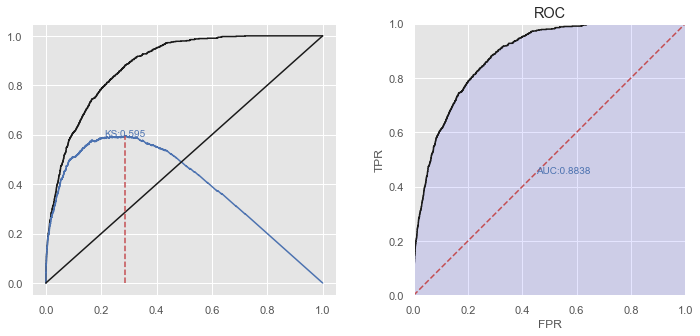

In [87]:
PertFunc.eva_plot(tra_y,tra_pred_y)

In [88]:
roc_auc_score(tst_y,tst_pred_y)

0.8085292549741742

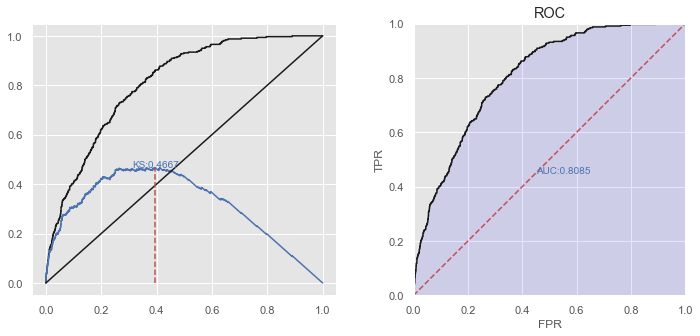

In [89]:
PertFunc.eva_plot(tst_y,tst_pred_y)

In [90]:
mat = confusion_matrix(tra_y,tra_pred_tag)
recall = mat[0,0]/(mat[0,0]+mat[0,1])
print(f'recall:{recall:.6f}')

recall:0.997033


In [91]:
mat = confusion_matrix(tst_y,tst_pred_tag)
mat[0,0]/(mat[0,0]+mat[0,1])
print(f'recall:{recall:.6f}')

recall:0.997033


#### 3.4 预测测试集结果

In [92]:
out_pred_y = clf.predict_proba(out_x_woe)[:,1]

In [93]:
out['Y_PRED'] = out_pred_y

In [94]:
out.to_csv('out_pred.csv',index=False)